## Panel 2 — Hawaii in Context

**Goal:** Compare Hawaii’s firearm death rate (per 100k) versus five large states (California, Texas, Florida, Illinois, Pennsylvania) across 2014–2024.

**Why per‑capita?** Raw counts are dominated by population size; per‑capita normalizes for fair comparisons.

In [17]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path('/Users/johnnybae/Documents/Academia/Chaminade/DS495 - Research')

inc = pd.read_csv(DATA_DIR/'Incidents/incidents_all_years.csv.gz',     na_values=['N/A'], low_memory=False)
parts = pd.read_csv(DATA_DIR/'Participants/participants_all_years.csv.gz', na_values=['N/A'], low_memory=False)
pop = pd.read_csv('population.csv')

### Build incident-level table with `State` and `Year`

In [18]:
# Build incidents_enriched: add State + Year to each incident

need = [c for c in ['ID', 'State', 'Date'] if c in parts.columns]
pt = parts[need].copy()

dt = pd.to_datetime(pt['Date'], errors='coerce')
for fmt in ['%d-%b-%y', '%Y-%m-%d', '%m/%d/%Y', '%m/%d/%y']:
    bad = dt.isna()
    if not bad.any():
        break
    dt.loc[bad] = pd.to_datetime(pt.loc[bad, 'Date'], format=fmt, errors='coerce')

pt['Year'] = dt.dt.year

def first_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else pd.NA

id_map = (
    pt.groupby('ID', as_index=False)
    .agg({
        'State': first_mode,
        'Year': 'max'
        })
)

# Make numeric columns numeric in incidents
for c in ['Vic-Killed','Vic-Injured','Sus-Killed','Sus-Injured','Sus-Unharmed','Sus-Arrested']:
    if c in inc.columns:
        inc[c] = pd.to_numeric(inc[c], errors='coerce')

# Merge to create incidents_enriched
incidents_enriched = inc.merge(id_map, on='ID', how='left')
incidents_enriched = incidents_enriched.dropna(subset=['Year'])

print(incidents_enriched[['ID','State','Year']].head())
print(f"Incidents enriched: {len(incidents_enriched):,} rows")


/var/folders/vg/b0s2p58n6p14svh9j4syj9r00000gn/T/ipykernel_8279/1631683555.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(pt['Date'], errors='coerce')


          ID        State    Year
0  3040722.0   California  2014.0
1  3040717.0   California  2014.0
2   291511.0     Virginia  2014.0
3   278757.0  Mississippi  2014.0
4   277950.0     Virginia  2014.0
Incidents enriched: 428,678 rows


### Compute deaths per 100k (2014–2024) for Hawaii + five states

In [19]:
# State-year totals
state_year = (incidents_enriched.groupby(['State','Year'], dropna=True)
              .agg(killed=('Vic-Killed','sum'))
              .reset_index())

# Merge population (tidy CSV includes United States + CA, TX, FL, IL, PA, HI)
pop_states = pop[pop['State'] != 'United States'].copy()
sy = state_year.merge(pop_states, on=['State','Year'], how='inner')
sy['per100k'] = (sy['killed'] / sy['Population']) * 100000

states_of_interest = ['Hawaii','California','Texas','Florida','Illinois','Pennsylvania']
sy_sub = sy[sy['State'].isin(states_of_interest)].copy()
sy_sub = sy_sub.sort_values(['State','Year'])
sy_sub.head()

,State,Year,killed,Population,per100k
0,California,2014.0,1181.0,38586700,3.060640
1,California,2015.0,1189.0,38904300,3.056217
2,California,2016.0,1268.0,39149200,3.238891
3,California,2017.0,1271.0,39337800,3.230989
4,California,2018.0,1206.0,39437500,3.058003


### Poster figure: Multi-line trend — Hawaii vs 5 states (per 100k)

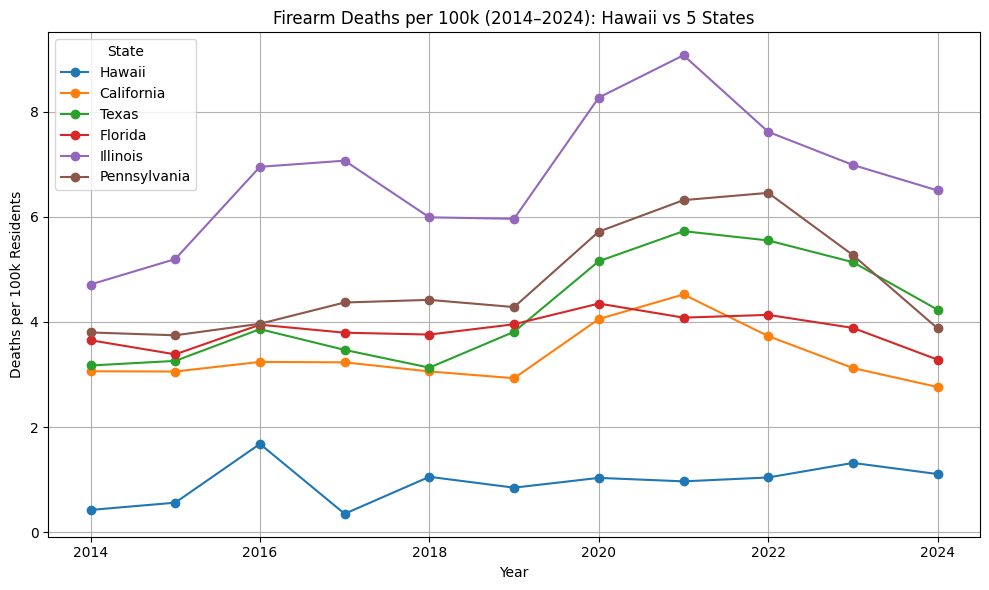

In [21]:
plt.figure(figsize=(10,6))
for st in states_of_interest:
    s = sy_sub[sy_sub['State']==st]
    plt.plot(s['Year'], s['per100k'], marker='o', label=st)
plt.title('Firearm Deaths per 100k (2014–2024): Hawaii vs 5 States')
plt.xlabel('Year'); plt.ylabel('Deaths per 100k Residents'); plt.legend(title='State', loc='upper left')
plt.grid(True)
plt.tight_layout(); plt.savefig('panel2_HIvStates.png', dpi=300)
plt.show()

### Compact figure: Average per 100k (2014–2024)

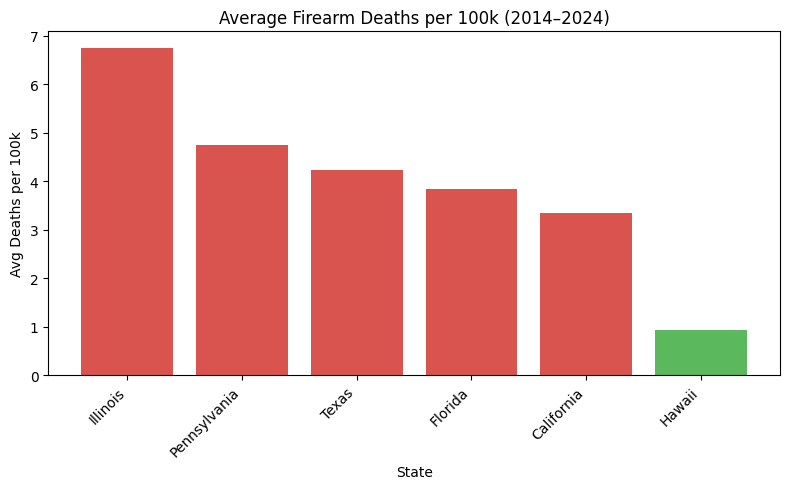

,State,per100k
3,Illinois,6.754796
4,Pennsylvania,4.746418
5,Texas,4.226898
1,Florida,3.838196
0,California,3.342098
2,Hawaii,0.944111


In [22]:
avg_pc = (sy_sub.groupby('State', as_index=False)['per100k']
          .mean().sort_values('per100k', ascending=False))
colors = ['#5cb85c' if s=='Hawaii' else '#d9534f' for s in avg_pc['State']]
plt.figure(figsize=(8,5))
plt.bar(avg_pc['State'], avg_pc['per100k'], color=colors)
plt.title('Average Firearm Deaths per 100k (2014–2024)')
plt.xlabel('State'); plt.ylabel('Avg Deaths per 100k'); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.savefig('panel2_avg_percap.png', dpi=300)
plt.show()
avg_pc

### Hawaiʻi’s National Rank in Firearm Deaths

In [24]:
inc_enriched = inc.merge(id_map, on='ID', how='left')

# Sum total deaths by state
state_counts = (
    inc_enriched.groupby('State', dropna=True)['Vic-Killed']
    .sum()
    .reset_index()
    .sort_values('Vic-Killed', ascending=False)
)

# Add rank
state_counts['Rank_by_Deaths'] = range(1, len(state_counts) + 1)

# Hawaii's rank row
hawaii_row = state_counts[state_counts['State'] == 'Hawaii']
display(hawaii_row)

,State,Vic-Killed,Rank_by_Deaths
11,Hawaii,149.0,48


### Hawai'i Firearm Deaths in 2024

In [26]:
hi_2024_deaths = (
    incidents_enriched[
        (incidents_enriched['State'] == 'Hawaii') &
        (incidents_enriched['Year'] == 2024)
    ]['Vic-Killed']
    .sum()
)

int(hi_2024_deaths)

16